$\newcommand{\mb}[1]{\mathbf{ #1 }}$
$\newcommand{\bs}[1]{\boldsymbol{ #1 }}$
$\newcommand{\bb}[1]{\mathbb{ #1 }}$

$\newcommand{\R}{\bb{R}}$

$\newcommand{\ip}[2]{\left\langle #1, #2 \right\rangle}$
$\newcommand{\norm}[1]{\left\Vert #1 \right\Vert}$

$\newcommand{\der}[2]{\frac{\mathrm{d} #1 }{\mathrm{d} #2 }}$
$\newcommand{\derp}[2]{\frac{\partial #1 }{\partial #2 }}$

# Finite Dimensional Koopman Bilinear System

Consider a nonlinear dynamical system that allows an exact finite dimensional Koopman canonical transform such that the control-affine dynamics can be transformed to a bilinear system. Consider the dynamical system 

\begin{equation}
\mb{\dot{x}}=\mb{f}_0(\mb x) + \mb f_1 ( \mb x) u_1 + \mb f_2(\mb x) u_2, 
\end{equation}

where we for this example choose $\mb f_0, \mb f_1$ as follows:

\begin{equation}
\mb f_0(\mb x) = \begin{bmatrix} x_3 \\ x_4 \\ \lambda x_3 \\ \mu x_4 + (2 \lambda - \mu) c x_3^2 \end{bmatrix}, \qquad
\mb f_1(\mb x) = \begin{bmatrix} 0 \\ 0 \\ 1 \\ 0 \end{bmatrix}, \qquad
\mb f_2(\mb x) = \begin{bmatrix} 0 \\ 0 \\ 0 \\ x_1+1 \end{bmatrix}, 
\end{equation}   

and $\lambda, \mu, c \in \mathbb{R}$ are scalar parameters of the system. Setting $ \mb x = [q_1 \, q_2 \, \dot{q_1} \, \dot{q_2}]^T$, 
these equations of motion can be expressed as robotic dynamics of the form $\mb{D}(\mb{q})\ddot{\mb{q}} + \mb{C}(\mb{q}, \dot{\mb{q}})\dot{\mb{q}} + \mb{G}(\mb{q}) = \mb{B}\mb{u}$, where $\mb D$ is the inertia matrix, $\mb C$ is the matrix of Coriolis terms, $\mb G$ is the matrix of gravitational terms, and $\mb B$ is the static actuation matrix. Rewriting $\mb f_0, \mb f_1, \mb f_2$ in terms of $\mb D, \mb C, \mb G,$ and $\mb B$ yield


\begin{equation}
\mb D(\mb q) = \begin{bmatrix} 1 & 0\\ 0 &  \frac{1}{q_1+1} \end{bmatrix}, 
\qquad \mb C(\mb q, \mb{\dot{q}}) = -\begin{bmatrix} \lambda & 0 \\ \frac{1}{q_1 + 1}(2 \lambda - \mu) c \dot{q}_1 & \frac{1}{q_1 +1} \mu \end{bmatrix}, \qquad 
\mb G(\mb q) = \begin{bmatrix} 0 \\ 0 \end{bmatrix} 
\qquad \mb B = \begin{bmatrix}1 & 0 \\ 0 & 1 \end{bmatrix},
\end{equation}

In [34]:
import numpy as np

from core.dynamics import RoboticDynamics

class FiniteDimKoopSys(RoboticDynamics):
    def __init__(self, lambd, mu, c):
        RoboticDynamics.__init__(self, 2, 2)
        self.params = lambd, mu, c
    
    def D(self, q):
        return np.array([[1, 0],[0, (q[0]+1)**(-1)]])
    
    def C(self, q, q_dot):
        labmd, mu, c = self.params
        return -np.array([[lambd, 0], [(q[0]+1)**(-1)*(2*lambd - mu)*c*q_dot[0], (q[0]+1)**(-1)*mu]])
    
    def G(self, q):
        return np.array([0, 0])
    
    def B(self, q):
        return np.array([[1, 0], [0, 1]])
    
lambd, mu, c = .3, .2, -.5
finite_dim_koop_sys = FiniteDimKoopSys(lambd, mu, c)

### Koopman Canonical Transform of the Control-Affine Dynamics

As a result of the careful construction of this system, there exists a Koopman canonical transform, $\mb z = T(\mb x)$ that exactly transforms the control-affine dynamics into a bilinear system. Consider the transformation:

\begin{equation}
    T(\mb q, \mb{\dot{q}}) = \begin{bmatrix} 
    \phi_1(\mb q, \mb{\dot{q}})\\
    \phi_2(\mb q, \mb{\dot{q}})\\
    \phi_3(\mb q, \mb{\dot{q}})\\
    \phi_4(\mb q, \mb{\dot{q}})\\
    \phi_5(\mb q, \mb{\dot{q}})\\
    \phi_6(\mb q, \mb{\dot{q}})\\
    \end{bmatrix}
    = \begin{bmatrix} 
    q_1 - \frac{1}{\lambda}\dot{q}_1\\
    q_2 - \frac{1}{\mu} \dot{q}_2 + \frac{(2 \lambda - \mu)c}{2\lambda \mu} \dot{q}_1^2\\
    \dot{q}_1\\
    \dot{q}_2 - c \dot{q}_1^2\\
    \dot{q}_1^2\\
    1
    \end{bmatrix},
\end{equation}

where $\phi_1, \phi_2, \phi_3, \phi_4, \phi_5, \phi_6$ are eigenfunctions of the Koopman operator associated with the drift 
vector field $\mb f_0$. The matrix with the eigenvalue associated with the i-th eigenfunction on the i-th diagonal 
element is $F=\text{diag}(0, 0, \lambda, \mu, 2 \lambda, 0)$. Then, to reformulate the dynamics we have:

\begin{equation} 
L_{\mb f_1} T(\mb q, \mb{\dot{q}}) = \begin{bmatrix} -\frac{1}{\lambda}\\ \frac{(2\lambda - \mu)c}{\lambda \mu}\dot{q}_1\\ 1 \\ -2c\dot{q}_1 \\ 2\dot{q_1} \\ 0 \end{bmatrix}, \qquad 
L_{\mb f_2} T(\mb q, \mb{\dot{q}}) = \begin{bmatrix} 0\\ -\frac{1}{\mu}(q_1 + 1)\\0 \\ q_1 + 1 \\ 0 \\ 0 \end{bmatrix} 
\end{equation}

and the dynamics can be equivalently transformed to a bilinear form $\mb{\dot{z}} = F \mb z + G_1\mb z u_1 + G_2\mb z u_2$ with

\begin{equation}
F = \begin{bmatrix} 
0 & 0 & 0 & 0 & 0 & 0\\
0 & 0 & 0 & 0 & 0 & 0\\
0 & 0 & \lambda & 0 & 0 & 0\\
0 & 0 & 0 & \mu & 0 & 0\\
0 & 0 & 0 & 0 & 2 \lambda & 0\\
0 & 0 & 0 & 0 & 0 & 0\\  
\end{bmatrix}, \qquad 
G_1 = \begin{bmatrix} 
0 & 0 & 0 & 0 & 0 & -\frac{1}{\lambda}\\
0 & 0 & \frac{(2\lambda - \mu)c}{\lambda \mu} & 0 & 0 & 0\\
0 & 0 & 0 & 0 & 0 & 1\\
0 & 0 & -2c & 0 & 0 & 0\\
0 & 0 & 2 & 0 & 0 & 0\\
0 & 0 & 0 & 0 & 0 & 0\\  
\end{bmatrix}
, \qquad 
G_2 = \begin{bmatrix} 
0 & 0 &  0 & 0 & 0 & 0\\
-\frac{1}{\mu} & 0 &  -\frac{1}{\lambda \mu} & 0 & 0 & -\frac{1}{\mu}\\
0 & 0 & 0 & 0 & 0 & 0\\
1 & 0 & \frac{1}{\lambda} & 0 & 0 & 1\\
0 & 0 & 0 & 0 & 0 & 0\\
0 & 0 & 0 & 0 & 0 & 0\\  
\end{bmatrix}
\end{equation}

In [35]:
from koopman_core.dynamics.bilinear_dynamics import BilinearDynamics

F = np.array([[0, 0, 0, 0, 0, 0],
             [0, 0, 0, 0, 0, 0],
              [0, 0, lambd, 0, 0, 0],
              [0, 0, 0, mu, 0, 0],
              [0, 0, 0, 0, 2*lambd, 0],
              [0, 0, 0, 0, 0, 0]])
G_1 = np.array([[0, 0, 0, 0, 0, -1/lambd],
                [0, 0, (2*lambd - mu)*c/(lambd*mu), 0, 0, 0],
                [0, 0, 0, 0, 0, 1], 
                [0, 0, -2*c, 0, 0, 0], 
                [0, 0, 2, 0, 0, 0], 
                [0, 0, 0, 0, 0, 0]])
G_2 = np.array([[0, 0, 0, 0, 0, 0],
                [-1/mu, 0, -1/(lambd*mu), 0, 0, -1/mu],
                [0, 0, 0, 0, 0, 0], 
                [1, 0, 1/lambd, 0, 0, 1], 
                [0, 0, 0, 0, 0, 0], 
                [0, 0, 0, 0, 0, 0]])
G = [G_1, G_2]
phi_fun = lambda x: np.array([x[0] - 1/lambd*x[2],
                            x[1] - 1/mu*x[3] + (2*lambd - mu)*c/(2*lambd*mu)*x[2]**2,
                            x[2], 
                            x[3] - c*x[2]**2, 
                            x[2]**2, 
                            1])
n, m = 6, 2

koop_bilinear_sys = BilinearDynamics(n, m, F, G, phi_fun)

With the same objective as before, we aim to design a feedback linearizing control law utilizing the bilinear dynamics. 
We assume that the outputs can be linearly described in the lifted state space such that $\mb y = C^{\mb h} \mb z$. 
The outputs encoding the objective (driving the system to the origin) can then be described as

\begin{equation}
    \bs{\eta}(\mb{q}, \dot{\mb{q}}) = C^{\mb h} \mb z - \mb y_d(t), 
    \qquad C^{\mb h} = \begin{bmatrix} 1 & 0 & \frac{1}{\lambda} & 0 & 0 & 0\\
    0 & 1 & 0 & \frac{1}{\mu} & \frac{c}{\mu} - \frac{(2\lambda - \mu)c}{2\lambda \mu} & 0
    \end{bmatrix}
\end{equation}

Differentiating the outputs we get and writing the actuated dynamics $G_1 \mb z u_1 + G_2 \mb z u_2$ as $\hat{G}(\mb z) \mb u$ we get:

\begin{equation}
    \bs{\dot{\eta}} = C^{\mb h}\mb{\dot{z}} - \mb{\dot{y}}_d(t) = C^{\mb h} \big (\mb{\dot{z}} - \mb{\dot{z}}_d(t) \big ) = C^{\mb h} \big ( F \mb z + \hat{G}(\mb z)\mb u - \mb{\dot{z}}_d \big ).
\end{equation}

Because of the relative degree assumption on the outputs, each output $y_i(\mb x)=h_i(\mb x), i=1,\dots,k$ has relative degree 2,
we have that $L_g h(x) = C^{\mb h} \hat{G}(\mb z) = 0$. As a result, $\bs{\dot{\eta}} = C^{\mb h} \big ( F \mb z - \mb{\dot{z}}_d \big )$.
Now, akin to classical feedback linearization we differentiate the outputs again to get:

\begin{equation}
    \bs{\ddot{\eta}} = C^{\mb h} \big ( F \mb{\dot{z}} - \mb{\ddot{z}}_d \big ) = C^{\mb h} \big ( F(F \mb z + \hat{G}(\mb z)\mb u)- \mb{\ddot{z}}_d \big )
    = C^{\mb h} \big ( F^2 \mb z + F\hat{G}(\mb z)\mb u - \mb{\ddot{z}}_d \big )
\end{equation}

Now, the output error dynamics can be written in normal form such that we get:

\begin{equation}
    \bs{\Phi}(\mb{q}, \dot{\mb{q}}) = \begin{bmatrix} \bs{\eta}(\mb{q}, \dot{\mb{q}})\\ \bs{\dot{\eta}}(\mb{q}, \dot{\mb{q}})\end{bmatrix}, \qquad
    \bs{\dot{\Phi}} = \begin{bmatrix} \bs{\dot{\eta}}\\ \bs{\ddot{\eta}}\end{bmatrix} =
    \begin{bmatrix} \bs{\dot{\eta}}\\
    C^{\mb h} \big ( F(F \mb z + \hat{G}(\mb z)\mb u)- \mb{\ddot{z}}_d \big ) \end{bmatrix}
\end{equation}

In [36]:
from core.dynamics.configuration_dynamics import ConfigurationDynamics

class BilinearSysOutput(ConfigurationDynamics):
    def __init__(self, bilinear_dynamics, C_h):
        ConfigurationDynamics.__init__(self, bilinear_dynamics, 1)
        self.bilinear_dynamics = bilinear_dynamics
        self.C_h = C_h
    
    def y(self, x):
        z = self.bilinear_dynamics.phi_fun(x)
        return np.dot(self.C_h, z)
        
    def dydx(self, x):
        return np.array([[1, 0, 0, 0],[0, 1, 0, 0]])
    
    def d2ydz2(self, x):
        return np.zeros((1, self.k, 4))

    def y_d(self, t):
        return np.dot(self.C_h, self.z_d(t))

    def y_d_dot(self, t):
        return np.dot(self.C_h, self.z_d_dot(t))

    def y_d_ddot(self, t):
        return np.dot(self.C_h, self.z_d_ddot(t))
    
    def z_d(self, t):
        return np.array(([0, 0, 0, 0, 0, 1]))

    def z_d_dot(self, t):
        return np.zeros(self.bilinear_dynamics.n)

    def z_d_ddot(self, t):
        return np.zeros(self.bilinear_dynamics.n)

C_h = np.array([[1, 0, 1/lambd, 0, 0, 0], 
                [0, 1, 0, 1/mu, c/mu - ((2*lambd - mu)*c)/(2*lambd*mu), 0]])
output_bl_fb = BilinearSysOutput(koop_bilinear_sys, C_h)



### Collect data from the system under PD control

We first collect data from the system under PD control designed by LQR on the linearization of the dynamics around the 
origin. This is done by picking 20 intial conditions $\mb x_0 = [q_0, \dot{q}_0]^T$ uniformly at random in the space 
$\mb x_0 \in [-5, 5]^2$. The linearized dynamics around the origin are:

In [37]:
from core.dynamics import ConfigurationDynamics

class FiniteDimKoopSysOutput(ConfigurationDynamics):
    def __init__(self, finite_dim_koop_sys):
        ConfigurationDynamics.__init__(self, finite_dim_koop_sys, 2)
        self.finite_dim_koop_sys = finite_dim_koop_sys
    
    def y(self, q):
        return q
        
    def dydq(self, q):
        return np.array([[1, 0], [0, 1]])
    
    def d2ydq2(self, q):
        return np.zeros((1, 2, 2))
    
output = FiniteDimKoopSysOutput(finite_dim_koop_sys)

In [38]:
from core.controllers import FBLinController, LQRController
q, r = 5, 1
Q_fb = q * np.identity(4)
R_fb = r*np.identity(2)
lqr = LQRController.build(output, Q_fb, R_fb)
fb_lin = FBLinController(output, lqr)

Finally, we collect the data and store the state and action pairs that will be used to learn dynamics models later on:

In [39]:
import random as rn
from koopman_core.controllers.perturbed_controller import PerturbedController

Ntraj = 50                                                 # Number of trajectories to collect data from
dt = 1.0e-2                                                 # Time step length
N = int(5./dt)                                              # Number of time steps
t_eval = dt * np.arange(N + 1)                              # Simulation time points
traj_bounds = [2., 2., 2., 2.]                                        # State constraints, [q, q_dot]
pert_noise_var = .5                                        # Variance of controller perturbation noise

pert_lqr_controller = PerturbedController(finite_dim_koop_sys, fb_lin, pert_noise_var)

xs, us, us_nom, ts = [], [], [], []
for ii in range(Ntraj):
    x_0 = np.asarray([rn.uniform(-i,i)  for i in traj_bounds])
    print(x_0)
    xs_tmp, us_tmp = finite_dim_koop_sys.simulate(x_0, pert_lqr_controller, t_eval)
    xs.append(xs_tmp)
    us.append(us_tmp)
    ts.append(t_eval)

xs, us, ts = np.array(xs), np.array(us), np.array(ts)


[ 1.84986266 -1.0103985   1.81519175  1.90814639]
[-0.18276614  0.06438683 -0.830326    1.89088349]
[-1.16822389 -1.7359706   0.95388928 -1.56096624]
[-1.4722194  -0.46439274  1.54669968  0.44614443]
[ 0.96182673 -1.4799193  -1.66260409  0.07884943]
[-1.44165347  1.99021332  1.92787194  0.27732343]
[ 0.35648502 -0.46292214  1.57165985 -1.97155482]
[-1.87642195 -0.94503657 -1.35204035 -0.97009329]
[-0.68476631 -1.31098287 -1.77933958  1.95624455]
[ 1.20150372 -1.82675229 -1.27796241  1.72594938]
[ 1.03546032  0.49580197  1.47652478 -1.70813472]
[-1.9210677   1.49717364  1.51146773 -0.3811907 ]
[-1.61303052 -0.17053929  0.0268925  -1.1997332 ]
[ 1.31877794  1.73039475 -1.36169771  1.19619061]
[-1.78276767  1.49954824  0.4187397   0.3123516 ]
[-1.15485388  0.54153525  0.72291575  1.39948865]
[0.63247539 1.03098745 0.45248529 1.71016341]
[ 1.85852051  1.53458771 -1.35935569  1.27132154]
[ 0.13903325 -1.42901067 -0.56121418  0.78662829]
[-0.65998005  1.27161376 -1.57304565 -0.71254157]
[ 0.

### Learn lifted linear state space model with EDMD

In [40]:
from koopman_core.learning.bilinear_basis_functions import BilinearBasis
from koopman_core.learning.utils import differentiate_vec
from sklearn.preprocessing import PolynomialFeatures

n, degree = 4, 2
poly_features = PolynomialFeatures(degree=2)
poly_features.fit(np.zeros((1,n)))
n_lift = poly_features.n_output_features_
edmd_basis = lambda x: poly_features.transform(x)

zs = np.array([edmd_basis(xs[ii,:-1,:]) for ii in range(Ntraj)])
zs_u = np.concatenate((zs, us), axis=2)
zs_dot = np.array([differentiate_vec(zs[ii,:,:], t_eval[:-1]) for ii in range(Ntraj)])  #Numerical differentiate lifted state

order = 'F'
n_data_pts = Ntraj*(t_eval.shape[0]-1)
xs_flat = xs[:,:-1,:].T.reshape((n, n_data_pts),order=order)
zs_flat = zs.T.reshape((n_lift, n_data_pts),order=order)
zs_u_flat = zs_u.T.reshape((n_lift+m, n_data_pts),order=order)
zs_dot_flat = zs_dot.T.reshape((n_lift, n_data_pts),order=order)

In [41]:
from sklearn import linear_model, preprocessing
from core.dynamics.linear_system_dynamics import LinearSystemDynamics

l1_edmd = 7e-2
edmd_model = linear_model.MultiTaskLasso(alpha=l1_edmd, fit_intercept=False, selection='random')
#edmd_model = linear_model.MultiTaskLassoCV(fit_intercept=False, selection='random')
edmd_standardizer = preprocessing.StandardScaler(with_mean=False)
edmd_standardizer.fit(zs_u_flat.T)
X_edmd = edmd_standardizer.transform(zs_u_flat.T)
y_edmd = zs_dot_flat.T
edmd_model.fit(X_edmd, y_edmd)
#print('edmd l1: ', edmd_model.alpha_)

# Parse learned coefficients into appropriate dynamics matrices
coefs_edmd = edmd_standardizer.transform(edmd_model.coef_)
A_edmd = coefs_edmd[:,:n_lift]
B_edmd = coefs_edmd[:,n_lift:]

C_h_edmd = np.zeros((n,n_lift))
C_h_edmd[:,1:n+1] = np.eye(n)
edmd_sys = LinearSystemDynamics(A_edmd, B_edmd)

### Learn lifted bilinear state space model with bEDMD

In [42]:
bedmd_basis = BilinearBasis(n, m, n_lift, edmd_basis)
bedmd_basis.construct_basis()

zs_bu = np.array([bedmd_basis.lift(xs[ii,:-1,:], us[ii,:,:]) for ii in range(Ntraj)])
zs_bu_flat = zs_bu.T.reshape(((m+1)*n_lift, n_data_pts),order=order)

In [43]:
l1_bedmd = 1e-1
bedmd_model = linear_model.MultiTaskLasso(alpha=l1_bedmd, fit_intercept=False, selection='random')
#bedmd_model = linear_model.MultiTaskLassoCV(fit_intercept=False, selection='random')
bedmd_standardizer = preprocessing.StandardScaler(with_mean=False)
bedmd_standardizer.fit(zs_bu_flat.T)
X_bedmd = bedmd_standardizer.transform(zs_bu_flat.T)
y_bedmd = zs_dot_flat.T
bedmd_model.fit(X_bedmd, y_bedmd)
#print('bedmd l1: ', bedmd_model.alpha_)

# Parse learned coefficients into appropriate dynamics matrices
coefs_bedmd = bedmd_standardizer.transform(bedmd_model.coef_)
F_bedmd = coefs_bedmd[:,:n_lift]
G_bedmd = []
for ii in range(m):
    G_bedmd.append(coefs_bedmd[:,n_lift*(ii+1):n_lift*(ii+2)])

C_h_bedmd = np.zeros((n,n_lift))
C_h_bedmd[:,1:n+1] = np.eye(n)
bedmd_sys = BilinearDynamics(n_lift, m, F_bedmd, G_bedmd, edmd_basis)

### Compare prediction performance of the linear and bilinear models

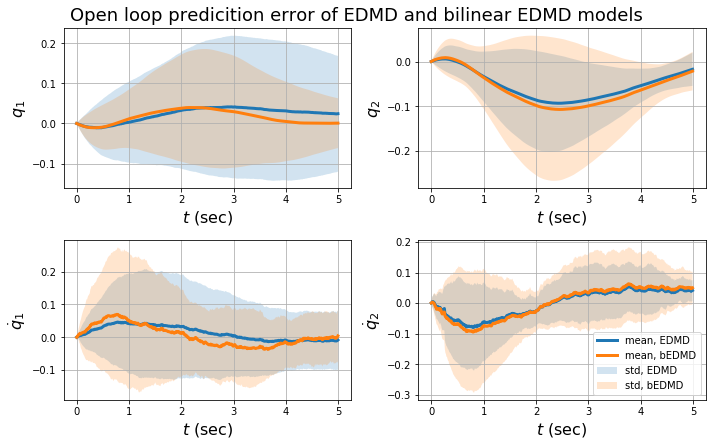

MSE EDMD:  0.013832630500855805 
MSE bilinear EDMD:  0.015551478414918218 
Improvement:  -12.426037939465463  percent


In [44]:
from matplotlib import pyplot as plt
from koopman_core.controllers.openloop_controller import OpenLoopController

Ntraj_test = 10
xs_test, xs_edmd_test, xs_bedmd_test, us_test, ts_test = [], [], [], [], []
for ii in range(Ntraj_test):
    x_0 = np.asarray([rn.uniform(-i,i)  for i in traj_bounds])
    xs_tmp, us_tmp = finite_dim_koop_sys.simulate(x_0, pert_lqr_controller, t_eval)

    ol_controller = OpenLoopController(bedmd_sys, us_tmp, t_eval[:-1])
    z_0 = edmd_basis(np.atleast_2d(x_0)).squeeze()

    zs_edmd_tmp, _ = edmd_sys.simulate(z_0, ol_controller, t_eval[:-1])
    xs_edmd_tmp = np.dot(C_h_edmd, zs_edmd_tmp.T)

    zs_bedmd_tmp, _ = bedmd_sys.simulate(z_0, ol_controller, t_eval[:-1])
    xs_bedmd_tmp = np.dot(C_h_bedmd, zs_bedmd_tmp.T)

    xs_test.append(xs_tmp.T)
    xs_edmd_test.append(xs_edmd_tmp)
    xs_bedmd_test.append(xs_bedmd_tmp)
    us_test.append(us_tmp)
    ts_test.append(t_eval)

xs_test, xs_edmd_test, xs_bedmd_test, us_test, ts_test = np.array(xs_test), np.array(xs_edmd_test), np.array(xs_bedmd_test), np.array(us_test), np.array(ts_test)

error_edmd = xs_test[:,:,:-1] - xs_edmd_test
error_edmd_mean = np.mean(error_edmd, axis=0)
error_edmd_std = np.std(error_edmd, axis=0)
mse_edmd = np.mean(np.mean(np.mean(np.square(error_edmd))))

error_bedmd = xs_test[:,:,:-1] - xs_bedmd_test
error_bedmd_mean = np.mean(error_bedmd, axis=0)
error_bedmd_std = np.std(error_bedmd, axis=0)
mse_bedmd = np.mean(np.mean(np.mean(np.square(error_bedmd))))

fig, axs = plt.subplots(2, 2, figsize=(10, 6))
ylabels = ['$q_1$', '$q_2$', '$\dot{q}_1$', '$\dot{q}_2$']
fig.suptitle('Open loop predicition error of EDMD and bilinear EDMD models', y=1.025, fontsize=18)
for ax, err_edmd_mean, err_edmd_std, err_bedmd_mean, err_bedmd_std, ylabel in zip(axs.flatten(), error_edmd_mean, error_edmd_std, error_bedmd_mean, error_bedmd_std, ylabels):
    ax.plot(ts_test[0,:-1], err_edmd_mean, linewidth=3, label='mean, EDMD')
    ax.fill_between(ts_test[0,:-1], err_edmd_mean-err_edmd_std, err_edmd_mean+err_edmd_std, alpha=0.2, label='std, EDMD')
    ax.plot(ts_test[0,:-1], err_bedmd_mean, linewidth=3, label='mean, bEDMD')
    ax.fill_between(ts_test[0,:-1], err_bedmd_mean-err_bedmd_std, err_bedmd_mean+err_bedmd_std, alpha=0.2, label='std, bEDMD')
    ax.set_ylabel(ylabel, fontsize=16)
    ax.grid()
    ax.set_xlabel('$t$ (sec)', fontsize=16)

ax.legend()
plt.tight_layout()
plt.show()
print('MSE EDMD: ', mse_edmd, '\nMSE bilinear EDMD: ', mse_bedmd, '\nImprovement: ', (1-mse_bedmd/mse_edmd)*100, ' percent')